<a href="https://colab.research.google.com/github/anushabhattachary/confusedmagiciangif/blob/main/qnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane

In [ ]:
!pip install tensorflow

In [ ]:
!pip install tqdm

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/content/"
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [ ]:
from pennylane.templates import StronglyEntanglingLayers, RandomLayers

dev = qml.device("default.qubit", wires=4)

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def random_entanglement_circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
strong_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4, 3))

@qml.qnode(dev)
def strongly_entangling_circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    StronglyEntanglingLayers(strong_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Visualizing RandomLayers Circuit:


TypeError: random_entanglement_circuit() got an unexpected keyword argument 'ax'

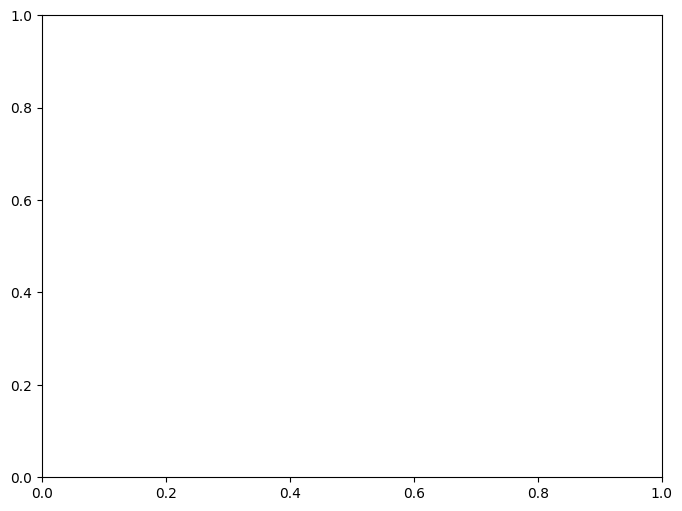

In [ ]:
import matplotlib.pyplot as plt

# Visualize the RandomLayers Circuit
phi_example = np.random.uniform(0, 1, size=4)  # Example input values
print("Visualizing RandomLayers Circuit:")
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size if needed
qml.draw_mpl(random_entanglement_circuit)(phi_example, ax=ax)
plt.title("RandomLayers Circuit")
plt.show()

# Visualize the StronglyEntanglingLayers Circuit
print("Visualizing StronglyEntanglingLayers Circuit:")
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size if needed
qml.draw_mpl(strongly_entangling_circuit)(phi_example, ax=ax)
plt.title("StronglyEntanglingLayers Circuit")
plt.show()


RandomLayers Circuit:
(<Figure size 500x500 with 1 Axes>, <Axes: >)
StronglyEntanglingLayers Circuit:
(<Figure size 500x500 with 1 Axes>, <Axes: >)


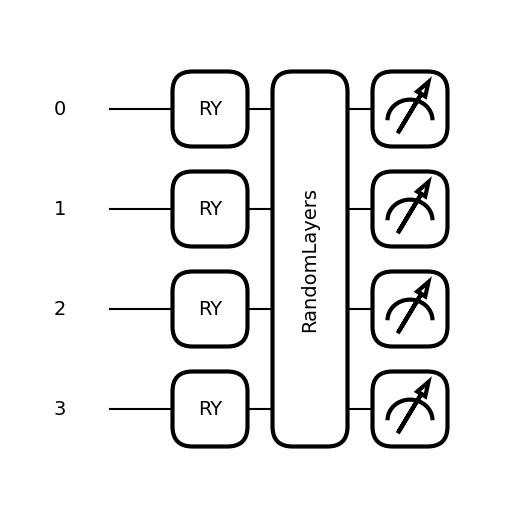

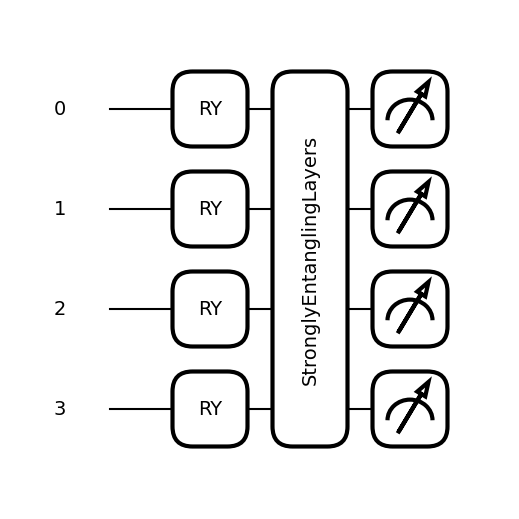

In [ ]:
# visualize circuit
phi_example = np.random.uniform(0, 1, size=4)

print("RandomLayers Circuit:")
print(qml.draw_mpl(random_entanglement_circuit)(phi_example))

print("StronglyEntanglingLayers Circuit:")
print(qml.draw_mpl(strongly_entangling_circuit)(phi_example))

In [ ]:
def quanv(image, circuit):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

In [ ]:
from tqdm import tqdm

if PREPROCESS == True:
  q_train_images_random = []
  print("Quantum pre-processing of train images with RandomLayers:")
  for img in tqdm(train_images, total=n_train, desc="RandomLayer train images"):
    q_train_images_random.append(quanv(img, random_entanglement_circuit))
  q_train_images = np.asarray(q_train_images_random)

  q_test_images_random = []
  print("\nQuantum pre-processing of test images with RandomLayers:")
  for img in tqdm(test_images, total=n_test, desc="RandomLayer test images"):
    q_test_images_random.append(quanv(img, random_entanglement_circuit))
  q_test_images = np.asarray(q_test_images_random)

  q_train_images_strong = []
  print("Quantum pre-processing of train images with StronglyEntanglingLayers:")
  for img in tqdm(train_images, total=n_train, desc="StronglyEntanglingLayer train images"):
    q_train_images_strong.append(quanv(img, strongly_entangling_circuit))
  q_train_images_strong = np.asarray(q_train_images_strong)

  q_test_images_strong = []
  print("\nQuantum pre-processing of test images with StronglyEntanglingLayers:")
  for img in tqdm(test_images, total=n_test, desc="StronglyEntanglingLayer test images"):
    q_test_images_strong.append(quanv(img, strongly_entangling_circuit))
  q_test_images_strong = np.asarray(q_test_images_strong)

  np.save(SAVE_PATH + "q_train_images_random.npy", q_train_images_random)
  np.save(SAVE_PATH + "q_test_images_random.npy", q_test_images_random)
  np.save(SAVE_PATH + "q_train_images_strong.npy", q_train_images_strong)
  np.save(SAVE_PATH + "q_test_images_strong.npy", q_test_images_strong)

Quantum pre-processing of train images with RandomLayers:


RandomLayer train images: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it]



Quantum pre-processing of test images with RandomLayers:


RandomLayer test images: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Quantum pre-processing of train images with StronglyEntanglingLayers:


StronglyEntanglingLayer train images: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]



Quantum pre-processing of test images with StronglyEntanglingLayers:


StronglyEntanglingLayer test images: 100%|██████████| 30/30 [00:59<00:00,  1.98s/it]


In [ ]:
q_train_images_random = np.load(SAVE_PATH + "q_train_images_random.npy")
q_test_images_random = np.load(SAVE_PATH + "q_test_images_random.npy")
q_train_images_strong = np.load(SAVE_PATH + "q_train_images_strong.npy")
q_test_images_strong = np.load(SAVE_PATH + "q_test_images_strong.npy")

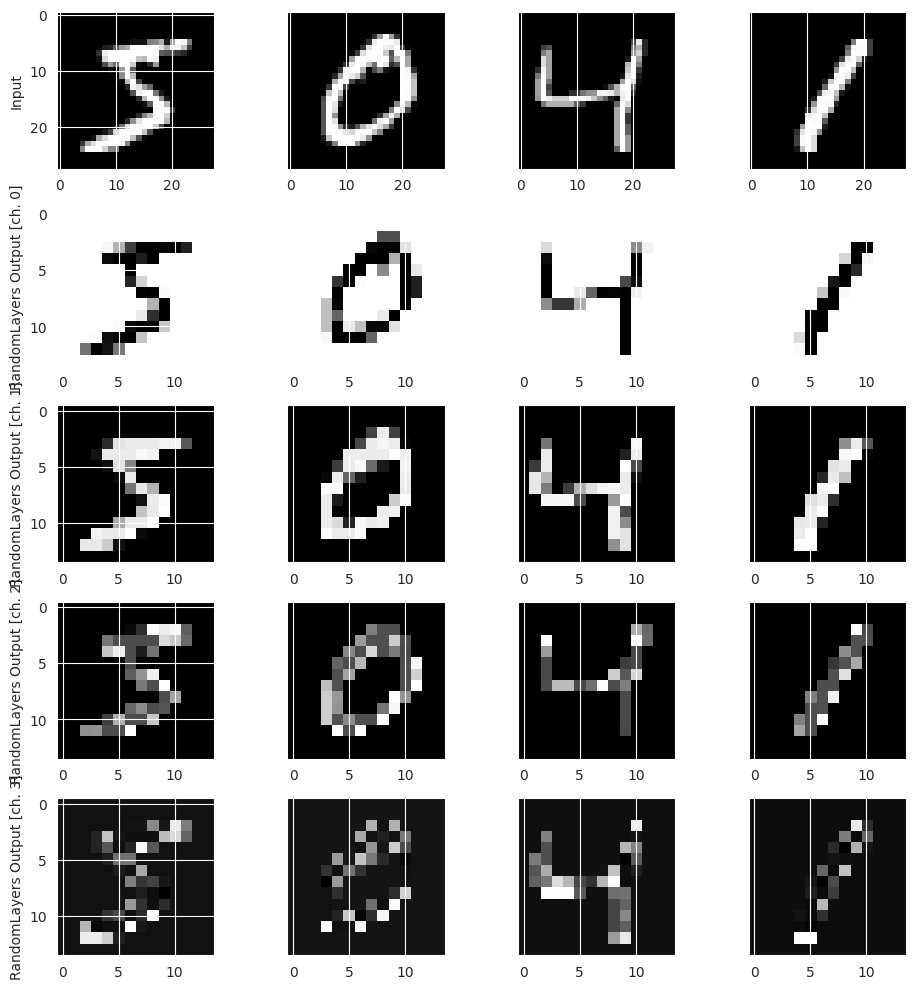

In [ ]:
# Random layers
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("RandomLayers Output [ch. {}]".format(c))
        if k != 0:
            axes[c + 1, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images_random[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

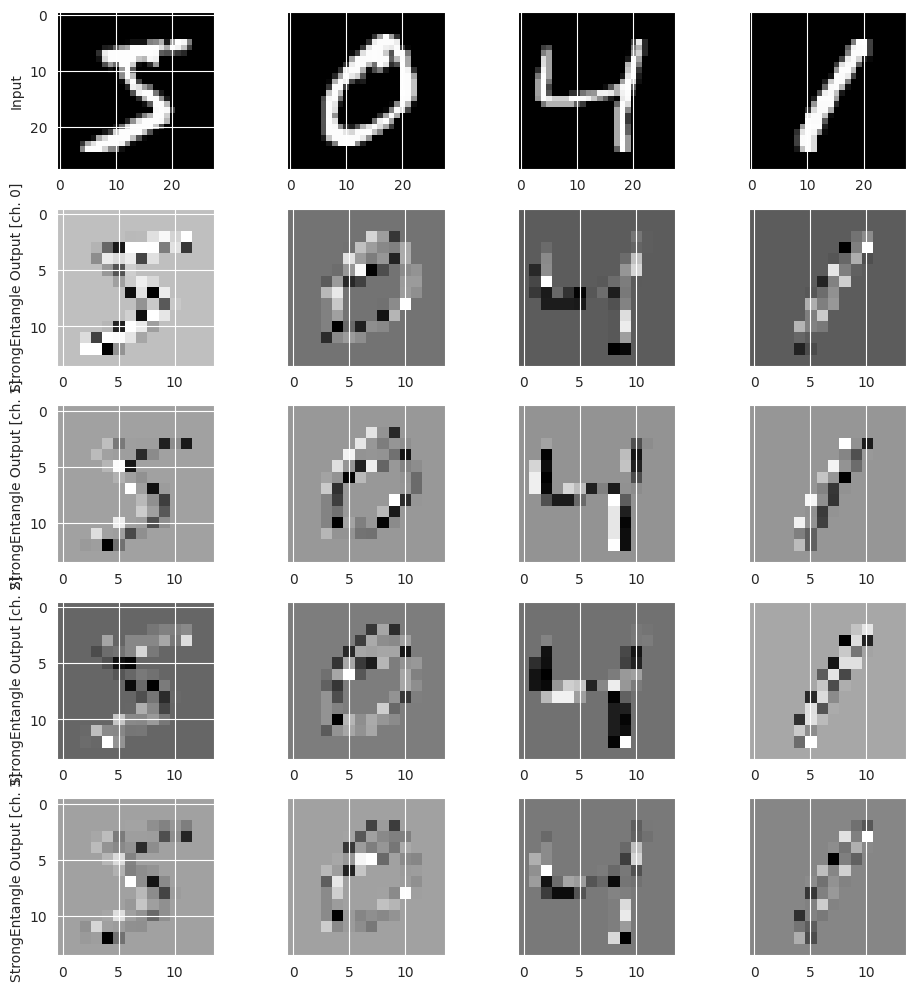

In [ ]:
# Plot StronglyEntanglingLayers-preprocessed images
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("StrongEntangle Output [ch. {}]".format(c))
        if k != 0:
            axes[c + 1, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images_strong[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

## Hybrid Qauntum-Classical Model

In [ ]:
def MyModel(input_shape):
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
def train_model(train_data, train_labels, test_data, test_labels, input_shape):
  model = MyModel(input_shape=input_shape)

  history = model.fit(
      train_data,
      train_labels,
      validation_data=(test_data, test_labels),
      batch_size=4,
      epochs=n_epochs,
      verbose=2,
  )
  return model, history

In [ ]:
# Training

print("\nTraining with RandomLayers-preprocessed data:")
model_random, history_random = train_model(q_train_images_random, train_labels, q_test_images_random, test_labels, input_shape=(14, 14, 4))

print("\nTraining with StronglyEntanglingLayers-preprocessed data:")
model_strong, history_strong = train_model(q_train_images_strong, train_labels, q_test_images_strong, test_labels, input_shape=(14, 14, 4))

print("\nTraining with classical (non-quantum) data:")
model_classical, history_classical = train_model(train_images, train_labels, test_images, test_labels, input_shape=(28, 28, 1))



Training with RandomLayers-preprocessed data:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
13/13 - 1s - 92ms/step - accuracy: 0.1200 - loss: 2.6538 - val_accuracy: 0.2000 - val_loss: 2.2958
Epoch 2/30
13/13 - 0s - 6ms/step - accuracy: 0.4000 - loss: 1.8256 - val_accuracy: 0.3667 - val_loss: 2.0777
Epoch 3/30
13/13 - 0s - 6ms/step - accuracy: 0.7600 - loss: 1.3338 - val_accuracy: 0.4000 - val_loss: 1.8563
Epoch 4/30
13/13 - 0s - 6ms/step - accuracy: 0.8000 - loss: 1.0155 - val_accuracy: 0.4333 - val_loss: 1.7005
Epoch 5/30
13/13 - 0s - 11ms/step - accuracy: 0.8800 - loss: 0.7684 - val_accuracy: 0.4333 - val_loss: 1.6097
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.5858 - val_accuracy: 0.4667 - val_loss: 1.5503
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9800 - loss: 0.4433 - val_accuracy: 0.5000 - val_loss: 1.4494
Epoch 8/30
13/13 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.3509 - val_accuracy: 0.5333 - val_loss: 1.4038
Epoch 9/30
13/13 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.2750 - val_accuracy: 0.5333 - val_loss: 1.3797
Epoch 10/30
13/

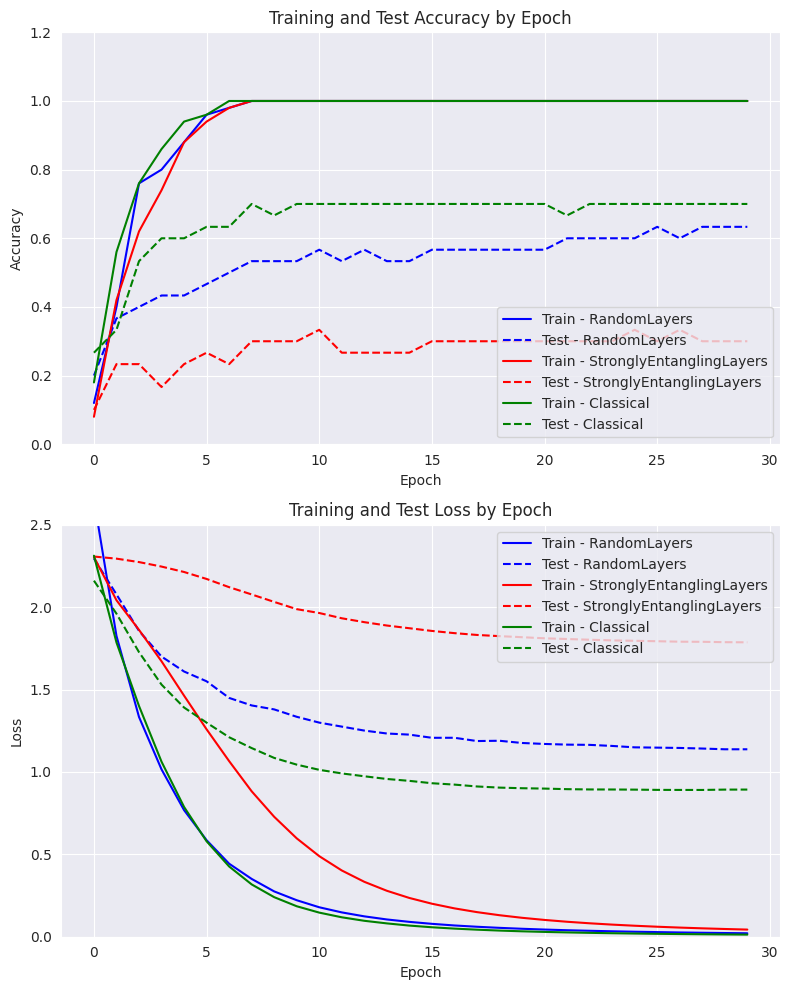

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style for matplotlib
sns.set_style("darkgrid")

# Initialize the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot Training and Validation Accuracy for each model type
ax1.plot(history_random.history["accuracy"], "-b", label="Train - RandomLayers")
ax1.plot(history_random.history["val_accuracy"], "--b", label="Test - RandomLayers")
ax1.plot(history_strong.history["accuracy"], "-r", label="Train - StronglyEntanglingLayers")
ax1.plot(history_strong.history["val_accuracy"], "--r", label="Test - StronglyEntanglingLayers")
ax1.plot(history_classical.history["accuracy"], "-g", label="Train - Classical")
ax1.plot(history_classical.history["val_accuracy"], "--g", label="Test - Classical")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1.2])
ax1.set_xlabel("Epoch")
ax1.legend(loc="lower right")
ax1.set_title("Training and Test Accuracy by Epoch")

# Plot Training and Validation Loss for each model type
ax2.plot(history_random.history["loss"], "-b", label="Train - RandomLayers")
ax2.plot(history_random.history["val_loss"], "--b", label="Test - RandomLayers")
ax2.plot(history_strong.history["loss"], "-r", label="Train - StronglyEntanglingLayers")
ax2.plot(history_strong.history["val_loss"], "--r", label="Test - StronglyEntanglingLayers")
ax2.plot(history_classical.history["loss"], "-g", label="Train - Classical")
ax2.plot(history_classical.history["val_loss"], "--g", label="Test - Classical")
ax2.set_ylabel("Loss")
ax2.set_ylim([0, 2.5])
ax2.set_xlabel("Epoch")
ax2.legend(loc="upper right")
ax2.set_title("Training and Test Loss by Epoch")

plt.tight_layout()
plt.show()

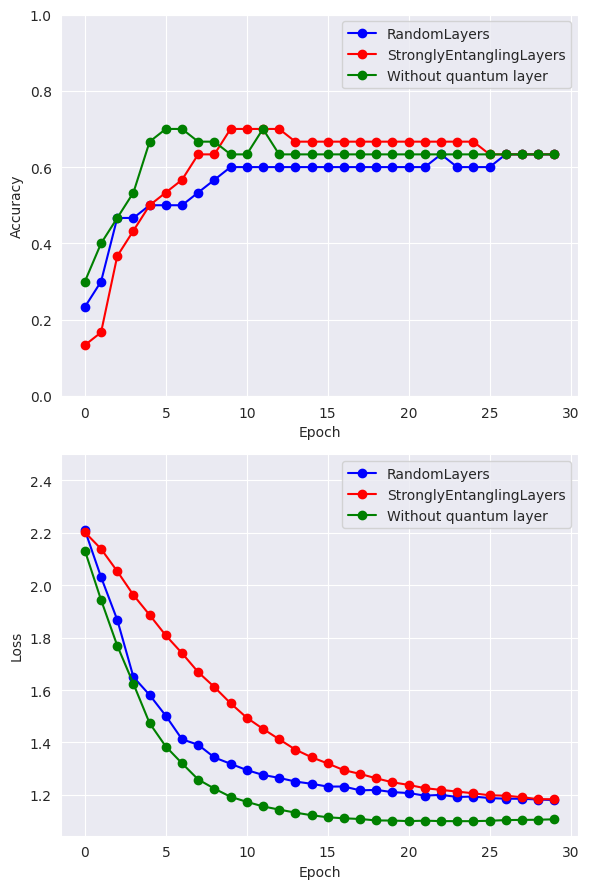

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style for matplotlib
sns.set_style("darkgrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

# Plot validation accuracy
ax1.plot(history_random.history["val_accuracy"], "-ob", label="RandomLayers")
ax1.plot(history_strong.history["val_accuracy"], "-or", label="StronglyEntanglingLayers")
ax1.plot(history_classical.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

# Plot validation loss
ax2.plot(history_random.history["val_loss"], "-ob", label="RandomLayers")
ax2.plot(history_strong.history["val_loss"], "-or", label="StronglyEntanglingLayers")
ax2.plot(history_classical.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()